# craters_cnn_attempt2-manual_dataset
In this notebook I use the exact same model as in craters_cnn_attempt2 and the much cleaner training set. Here the difference is 

In [42]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import io_ops,image_ops,array_ops,math_ops
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

## Generate a keras Dataset

In [2]:
data_fld = '/home/ahoag/ML/mars/attempt2/images_for_cnn'

In [4]:
no_craters_dir = os.path.join(data_fld,'no_craters')
images_no_craters = glob.glob(no_craters_dir+'/*jpg')
craters_dir = os.path.join(data_fld,'craters')
images_craters = glob.glob(craters_dir+'/*jpg')
all_image_paths = images_no_craters + images_craters
all_image_labels = [0 for x in images_no_craters] + [1 for y in images_craters]
all_image_labels = np.array((all_image_labels,), dtype='int32')

image_size=(180,180)
num_channels=3

def path_to_image(path, image_size, num_channels, interpolation):
    img = io_ops.read_file(path)
    img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
    img = image_ops.resize_images_v2(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img

In [23]:
all_image_data = np.array([path_to_image(x, image_size, num_channels, interpolation='bilinear') for x in all_image_paths])

all_label_data = np.array([array_ops.expand_dims(math_ops.cast(x, 'float32'), axis=-1) for x in all_image_labels])

In [53]:
all_label_data

array([[[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [33]:
all_label_data[0].shape

(1500, 1)

In [29]:
all_image_data.shape

(1500, 180, 180, 3)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
   all_image_data, all_label_data[0], test_size=0.2, random_state=42)

In [36]:
X_train.shape

(1200, 180, 180, 3)

In [37]:
X_val.shape

(300, 180, 180, 3)

In [38]:
y_train.shape

(1200, 1)

In [39]:
y_val.shape

(300, 1)

## Using image data augmentation

In [43]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

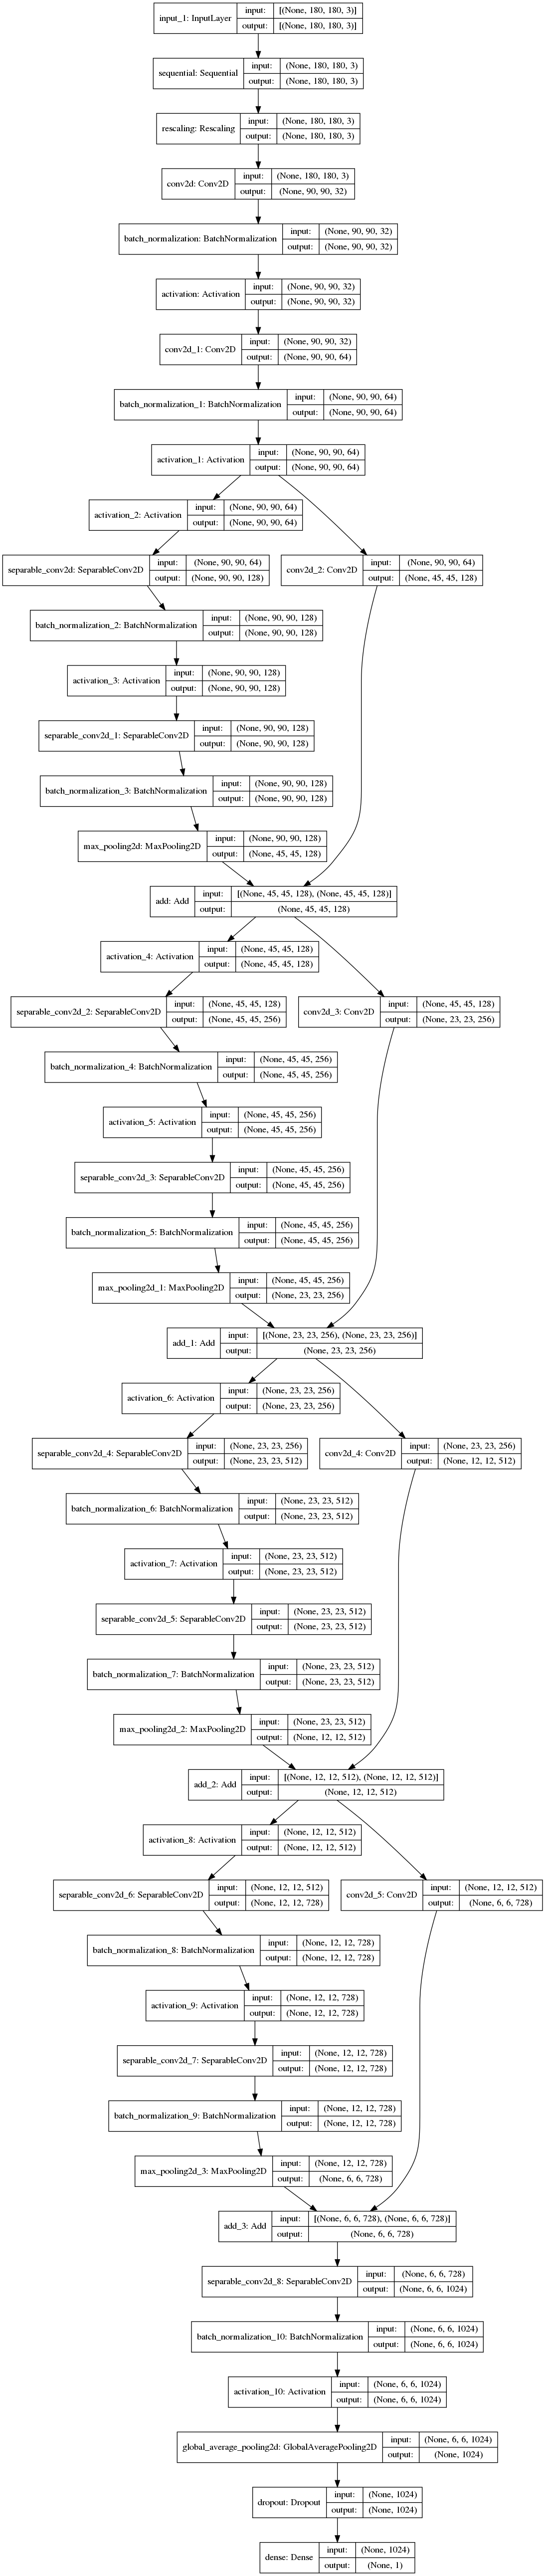

In [44]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [52]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint("/home/ahoag/ML/mars/attempt2_manualdata/cnn_saved_epochs/save_at_{epoch}_batches.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    x=X_train,y=y_train, batch_size=32, epochs=epochs, callbacks=callbacks, validation_data=(X_val,y_val),
)

Epoch 1/60
38/38 [==============================] - 54s 1s/step - loss: 0.1988 - accuracy: 0.9149 - val_loss: 0.4266 - val_accuracy: 0.8200
Epoch 2/60
13/38 [=========>....................] - ETA: 33s - loss: 0.1550 - accuracy: 0.9386

KeyboardInterrupt: 

## Evaluate the model

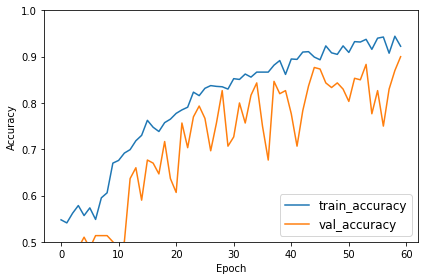

In [54]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()
plt.savefig('../attempt2/training_attempt2.png')

We get ~90% accuracy on the validation set after running for 60 epochs! This is significantly better than the previous run with the worse training set! 

## Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [56]:
test_fld = '/home/ahoag/ML/mars/attempt2/test_cnn'

In [57]:
max_val_acc = max(history.history['val_accuracy'])
history.history['val_accuracy'].index(max_val_acc)+1 

60

In [58]:
print(f"Maximum val_accuracy = {max_val_acc}")

Maximum val_accuracy = 0.8999999761581421


## Evaluate model (at epoch 60) on test set

In [72]:
# Load in test set
no_craters_dir_test = os.path.join(test_fld,'no_craters')
images_no_craters_test = glob.glob(no_craters_dir_test+'/*jpg')
craters_dir_test = os.path.join(test_fld,'craters')
images_craters_test = glob.glob(craters_dir_test+'/*jpg')
all_image_paths_test = images_no_craters_test + images_craters_test
all_image_labels_test = [0 for x in images_no_craters_test] + [1 for y in images_craters_test]
all_image_labels_test = np.array((all_image_labels_test,), dtype='int32')

all_image_data_test = np.array([path_to_image(x, image_size, num_channels, interpolation='bilinear') for x in all_image_paths_test])

all_label_data_test = np.array([array_ops.expand_dims(math_ops.cast(x, 'float32'), axis=-1) for x in all_image_labels_test])[0]

In [73]:
len(all_label_data_test)

304

In [74]:
len(all_image_data_test)

304

In [78]:
X_test = all_image_data_test
y_test = all_label_data_test

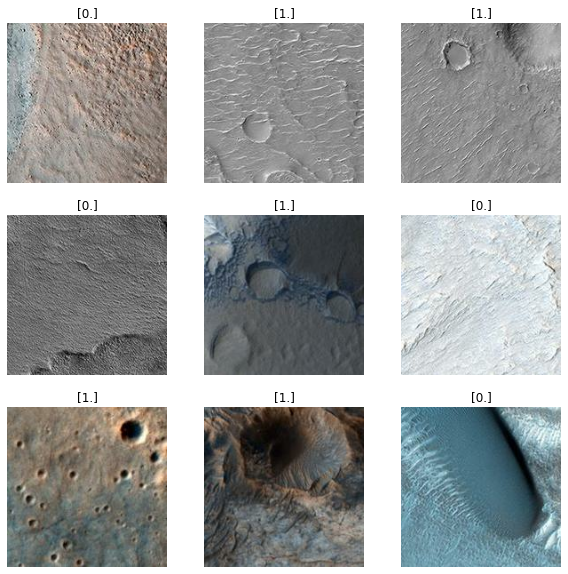

In [77]:
plt.figure(figsize=(10, 10))
# print("#[crater, dune]")
rand_indices = np.random.randint(0,len(all_label_data_test),9)
# print(rand_indices)
for ii in range(9):
    rand_index = rand_indices[ii]
    ax = plt.subplot(3, 3, ii + 1)
    plt.imshow(all_image_data_test[rand_index].astype("uint8"))
#         print()
    plt.title(str(all_label_data_test[rand_index]))
    plt.axis("off")

In [79]:
# Load in test images and labels
result = model.evaluate(x=X_test,y=y_test)

10/10 [==============================] - 3s 286ms/step - loss: 0.3949 - accuracy: 0.8717


Looks like my test-set accuracy is ~88%. This is the same as when I did this with the built-in keras data loader.

In [73]:
test_predictions = []
test_labels = []
test_probs = []
for x, y in test_ds:
    new_predictions = best_model.predict(x)[:,0]
    test_predictions.extend(list(map(round,new_predictions)))
    test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        test_probs.append(pred_float)
    

In [79]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = 'd'
    fmt_norm = '.2f'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt)+f' ({format(cm_norm[i, j], fmt_norm)})',
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

[[141   9]
 [ 25 129]]


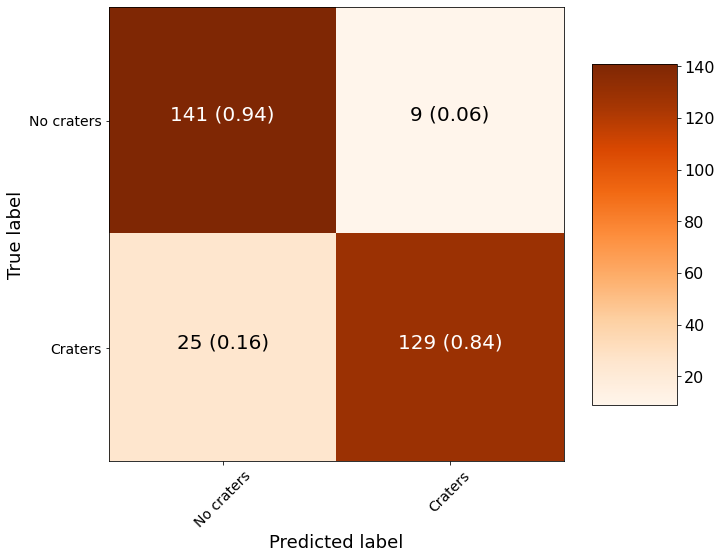

In [81]:
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, classes = ['No craters', 'Craters'],
                      title = '',
                     )
plt.savefig('../attempt2/confusion_matrix_attempt2.png')

Like the initial model, this model is very good at identifying what is NOT a crater. It has a harder time picking up all of the craters. Another way of saying this is the precision is very good but recall not as good. Let's compare ROC AUC curve to previous model.

In [76]:
train_predictions = []
train_labels = []
train_probs = []
for x, y in train_ds:
    new_predictions = best_model.predict(x)[:,0]
    train_predictions.extend(list(map(round,new_predictions)))
    train_labels.extend(list(map(round,y.numpy())))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        train_probs.append(pred_float)
    


In [42]:
previous_model_save_file = '../cnn_saved_epochs/best_model_epoch53.h5'
previous_model = keras.models.load_model(previous_model_save_file)

In [44]:
prevmodel_test_fld = '../test_set_attempt1'
prevmodel_test_ds = tf.keras.preprocessing.image_dataset_from_directory(prevmodel_test_fld,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)

Found 419 files belonging to 2 classes.


In [45]:
prevmodel_test_predictions = []
prevmodel_test_labels = []
prevmodel_test_probs = []
for x, y in prevmodel_test_ds:
    new_predictions = previous_model.predict(x)[:,0]
    prevmodel_test_predictions.extend(list(map(round,new_predictions)))
    prevmodel_test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        prevmodel_test_probs.append(pred_float)

In [67]:
def evaluate_model(predictions, probs, train_predictions, train_probs,prevmodel_predictions,prevmodel_probs):
    """
    Compare machine learning model to baseline and previous model performance.
    Computes statistics and shows ROC curve.
    ---INPUT---
    predictions:    predicted classes in the test set
    
    """
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    previous = {}
    
    previous['recall'] = recall_score(prevmodel_test_labels, [1 for _ in range(len(prevmodel_test_labels))])
    previous['precision'] = precision_score(prevmodel_test_labels, [1 for _ in range(len(prevmodel_test_labels))])
    previous['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)}'
              f' Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    prevmodel_fpr, prevmodel_tpr, _ = roc_curve(prevmodel_test_labels, prevmodel_probs)
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(prevmodel_fpr, prevmodel_tpr, 'g', label = 'Xception (lg train set, quick data)')
    plt.plot(model_fpr, model_tpr, 'r', label = 'Xception (sm train set, good data)' )
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.savefig('../attempt2/roc_auc_compare1and2.png')

Recall Baseline: 1.0 Test: 0.84 Train: 0.96
Precision Baseline: 0.51 Test: 0.93 Train: 0.97
Roc Baseline: 0.5 Test: 0.95 Train: 0.99


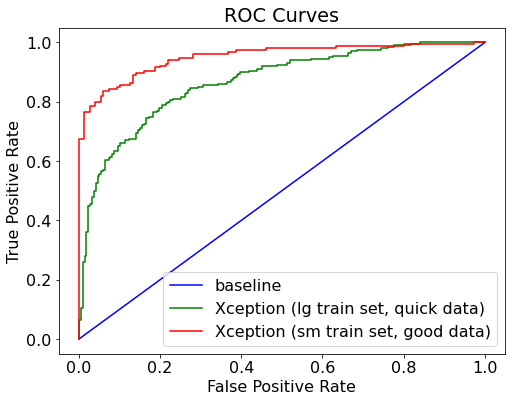

In [68]:
evaluate_model(test_predictions,test_probs,train_predictions, train_probs,
              prevmodel_test_predictions,prevmodel_test_probs)

In [63]:
roc_auc_score(test_labels, test_probs)

0.950865800865801

In [78]:
roc_auc_score(prevmodel_test_labels, prevmodel_test_probs)

0.8666666666666666

In [83]:
false_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_negatives.append(fn_dict)


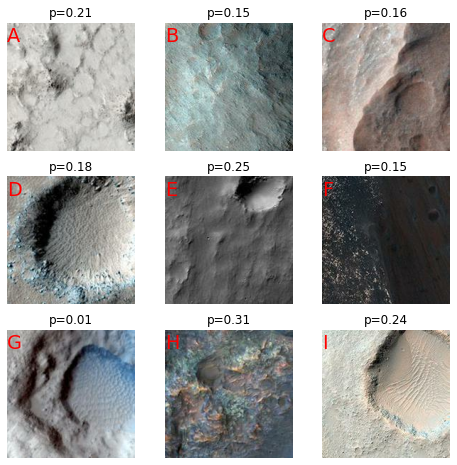

In [86]:
# inspect false negatives
# np.random.shuffle(false_negatives)
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
    plt.imshow(false_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = false_negatives[i]['pred']
    plt.title(f"p={pred_float:.2f}",fontsize=12)
    plt.text(0,0.85,chr(65+i),transform=ax.transAxes,color='r',fontsize='large')

    plt.axis("off")
plt.savefig('../attempt2/false_negatives_attempt2.png')

The bottom 3 of these look like hard cases. Really surprised case 4 was such a strong probability of not having a crater

In [215]:
true_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_positives.append(fn_dict)

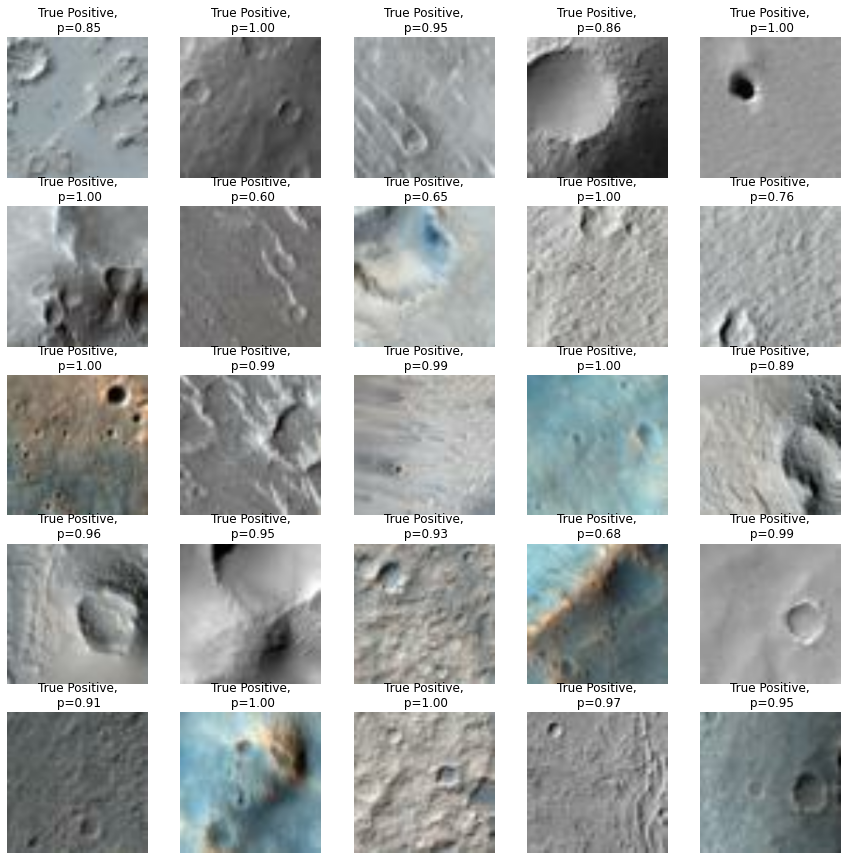

In [248]:
# inspect True positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_positives[i]['image'].numpy().astype("uint8"))
    pred_float = true_positives[i]['pred']
    plt.title(f"True Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

It definitely does seem like the more obvious craters are detected. One thing I am noticing is that in the true positives the backgrounds are much more uniform. In the false negatives (fail to detect a crater that is there) the backgrounds are much more colorful. 

In [221]:
all_probabilities = [] 

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        all_probabilities.append(pred_float)

Text(0, 0.5, 'N')

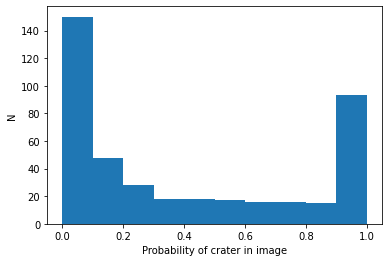

In [223]:
# Plot distribution of actual probabilities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_probabilities)
ax.set_xlabel('Probability of crater in image')
ax.set_ylabel('N')

## ROC - AUC curve

In [234]:
roc_auc_score?

This is about what I got for the titanic survival challenge which isn't bad!

Let's look at some false positives.

In [251]:
false_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_positives.append(fn_dict)

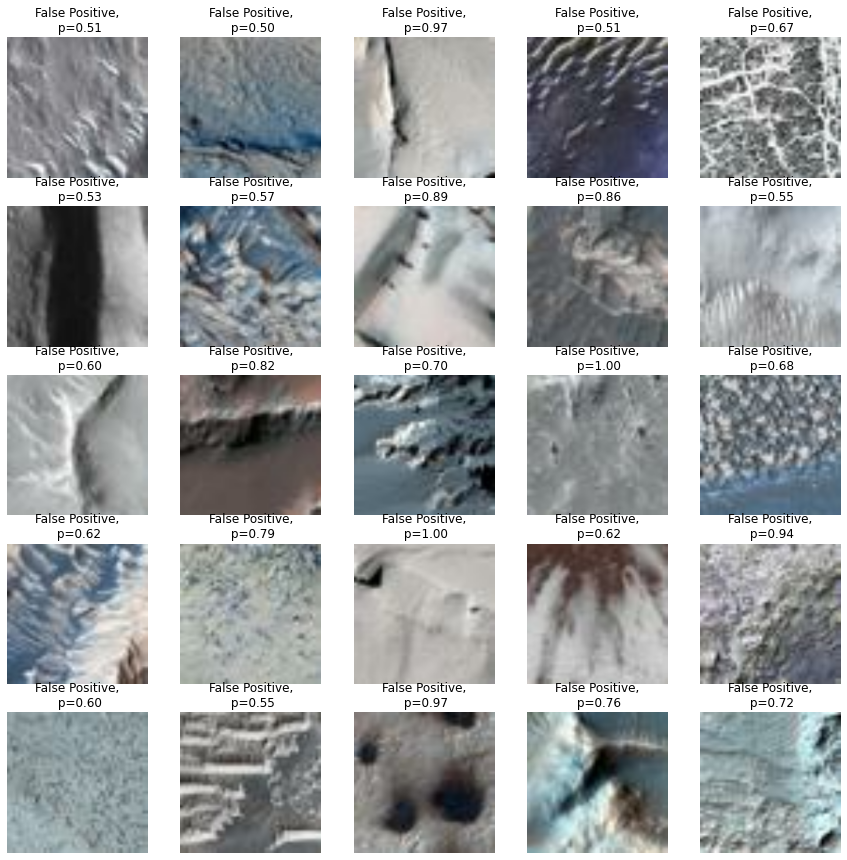

In [252]:
# inspect false positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(false_positives[i]['image'].numpy().astype("uint8"))
    pred_float = false_positives[i]['pred']
    plt.title(f"False Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

These have a similar background color to the true positives, so it might be using background color here. Another reason to use grayscale instead of color images. 

In [253]:
true_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_negatives.append(fn_dict)

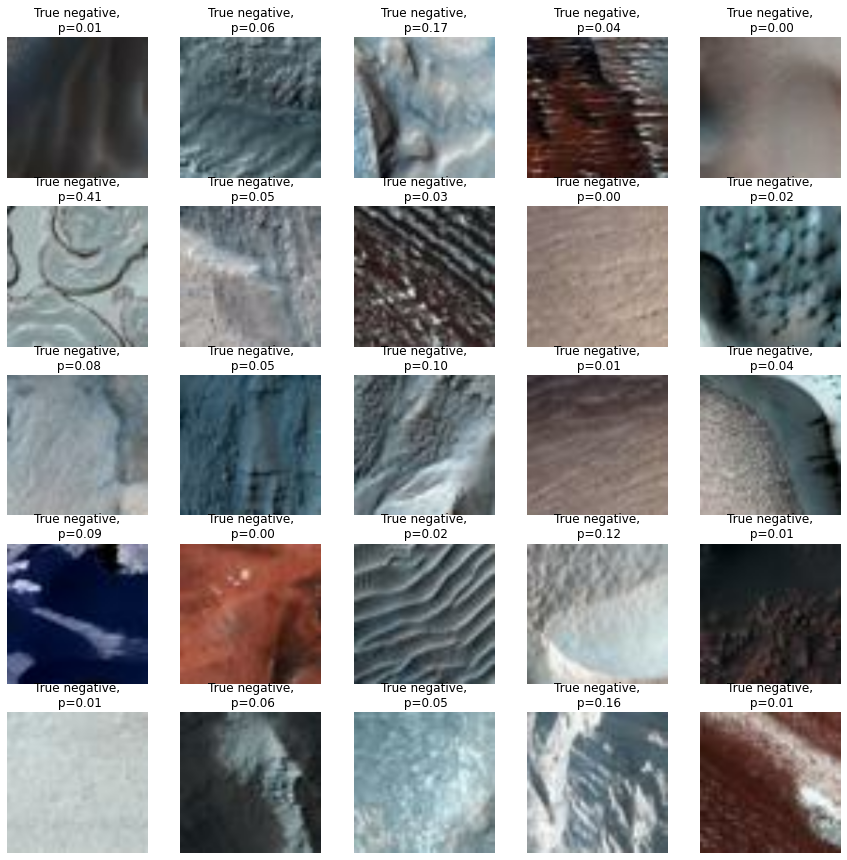

In [256]:
# inspect true negative
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = true_negatives[i]['pred']
    plt.title(f"True negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

## Things to do
- Run the model on the rest of the dataset.
- A bigger training/validation set. It's pretty amazing it is doing as well as it is given the limited size of the training set I used.
- Try using grayscale images instead of color. Color might be throwing off the model. 
- Figure out how to do cross validation with this kind of model
- Keras tuner
- Try different CNN architectures
- Try use_multiprocessing=True in model.fit() to see if we get improvement
- Try different image sizes to see if that helps/hurts training
- Purify training/val set to only include obvious craters
- Learn how to look at the intermediate filters in my model

## Done
- Make a test set and evaluate the model on that -- Take a look at confusion matrix/ ROC-AUC curve
